import autograd.numpy as np
import pylab as pl
import os,sys
import celerite
from celerite import terms
import scipy.optimize as op
import emcee
import corner
from tqdm import tqdm, tqdm_notebook

In [1]:
from run_celerite_3term_jitter import *

In [2]:
pl.rcParams['figure.figsize'] = [20, 5]
pl.rcParams['figure.dpi'] = 300

In [3]:
phi_fg = 10.
phi_gal = 50.

scen1 = False
scen2 = True

In [4]:
indir = "./rfi_flagged"
nu, l2, stokesQ, stokesU = read_data(indir, "all_params-thin.txt")

In [5]:
t1 = np.linspace(np.min(l2), np.max(l2), 512)

In [6]:
def make_scenario1(phi_gal, l2):
    
    p0 = 1.0
    alpha = 0.7
    nu0 = 1.4e9
    nu = 3e8/np.sqrt(l2)
    k = (nu/nu0)**(-1*alpha)
    mu_q = p0*k*np.cos(2.*phi_gal*l2)
    mu_u = p0*k*np.sin(2.*phi_gal*l2)
    
    p = np.mean(np.sqrt(mu_q**2+mu_u**2))
    
    return mu_q, mu_u

In [7]:
def make_scenario2(phi_fg, phi_gal, l2):
    
    p_fg = 1.0
    p_gal = 0.25
    mu_q = p_fg*np.sin(2*phi_fg*l2)/(2.*phi_fg*l2) + p_gal*np.cos(2.*phi_gal*l2)
    mu_u = p_gal*np.sin(2.*phi_gal*l2)
    
    return mu_q, mu_u

In [8]:
if scen1:
    mu_q, mu_u = make_scenario1(phi_gal, t1)
elif scen2:
    mu_q, mu_u = make_scenario2(phi_fg, phi_gal, t1)

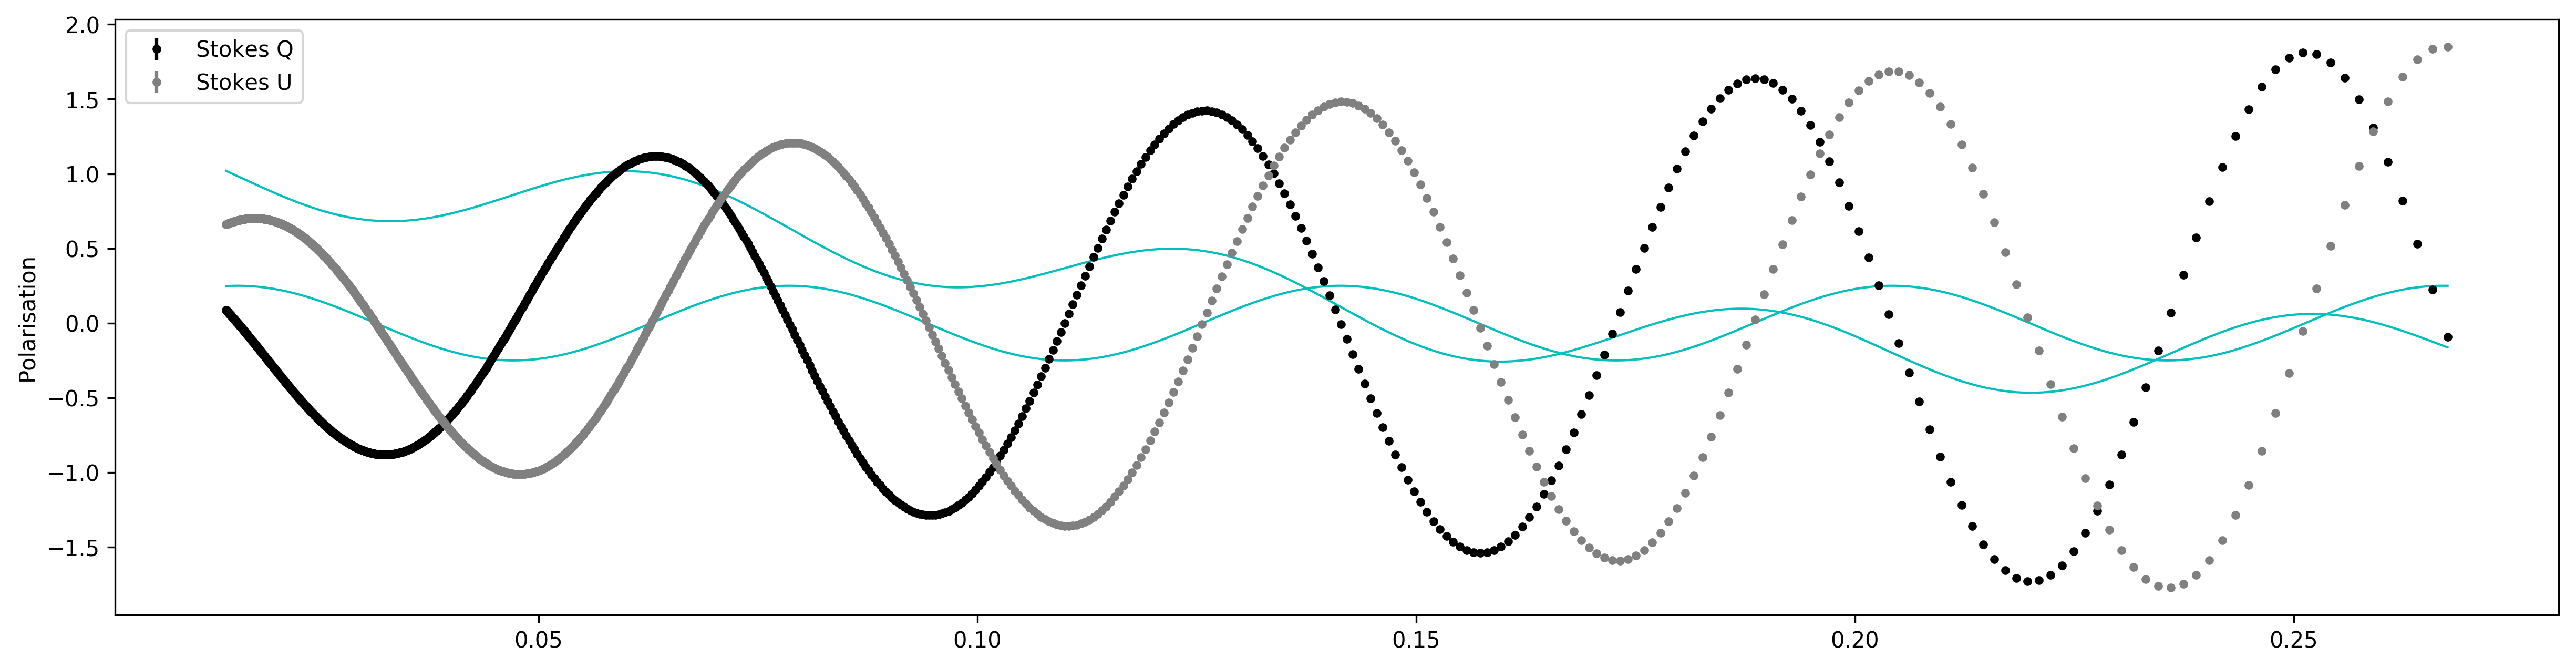

In [9]:
ax2 = pl.subplot(111)

ax2.plot(t1,mu_q, linestyle='-', color = 'c', lw=1.0)
ax2.plot(t1,mu_u, linestyle='-', color = 'c', lw=1.0)

ax2.errorbar(l2[::-1],stokesQ[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax2.errorbar(l2[::-1],stokesU[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax2.set_ylabel("Polarisation")

ax2.legend()
pl.show()

In [10]:
phi = np.linspace(-500,500,10000)

In [11]:
def calc_k(w):
    
    k = np.sum(w)
    
    return k

In [12]:
def calc_l0(w,l2):
    
    k = calc_k(w)
    l0 = (1./k)*np.sum(w*l2)
    
    return l0

In [13]:
def calc_f(phi,l2,q,u,w):
    
    p = q+1j*u
    k = calc_k(w)
    l0 = calc_l0(w,l2)
    f = (1./k)*np.sum(w*p*np.exp(-2*1j*(l2-l0)*phi))
    
    return f

In [14]:
def calc_r(phi,l2,w):
    
    k = calc_k(w)
    l0 = calc_l0(w,l2)
    r = (1./k)*np.sum(w*np.exp(-2*1j*(l2-l0)*phi))
    
    return r

In [15]:
fspec = []
rmtf = []
try:
    gp_var = std_q**2 + np.ones(len(std_q))
    w = 1./gp_var
except:
    w = np.ones(len(mu_q))
    
for i in range(0,len(phi)):
    fspec.append(calc_f(phi[i],t1,mu_q,mu_u,w))
    rmtf.append(calc_r(phi[i],t1,w))
    
fspec = np.array(fspec)
rmtf = np.array(rmtf)

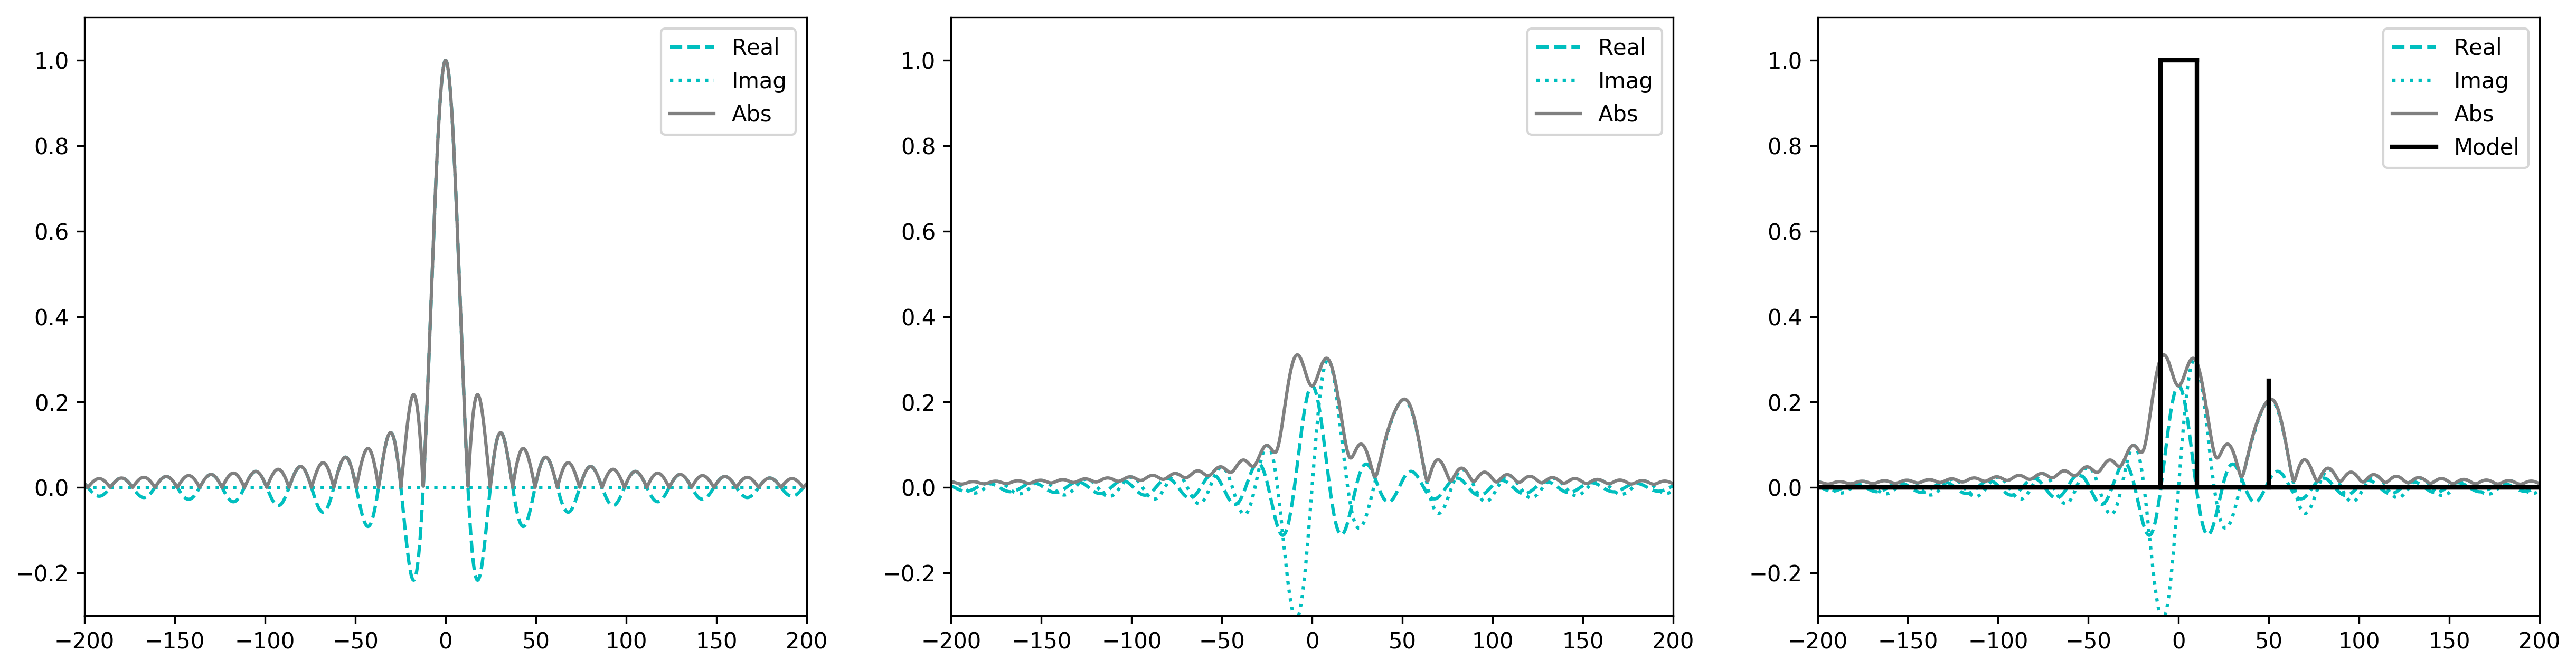

In [16]:
pl.subplot(131)
pl.plot(phi,np.real(rmtf),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(rmtf),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(rmtf),ls='-',c='grey',label="Abs")
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)
pl.legend()

pl.subplot(132)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.subplot(133)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")

pl.plot(phi,np.zeros(len(phi)),ls='-',lw=2.,c='black')
if scen1:
    pl.plot([50.,50.],[0.,1.4],ls='-',lw=2.,c='black')
elif scen2:
    pl.plot([50.,50.],[0.,0.25],ls='-',lw=2.,c='black')
    pl.plot([10.,10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,-10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,10.],[1.0,1.0],ls='-',lw=2.,c='black',label="Model")
    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.show()

In [17]:
fspec = []
rmtf = []
w = np.ones(len(stokesQ))
    
for i in range(0,len(phi)):
    fspec.append(calc_f(phi[i],l2[::-1],stokesQ[::-1],stokesU[::-1],w))
    rmtf.append(calc_r(phi[i],l2[::-1],w))
    
fspec = np.array(fspec)
rmtf = np.array(rmtf)

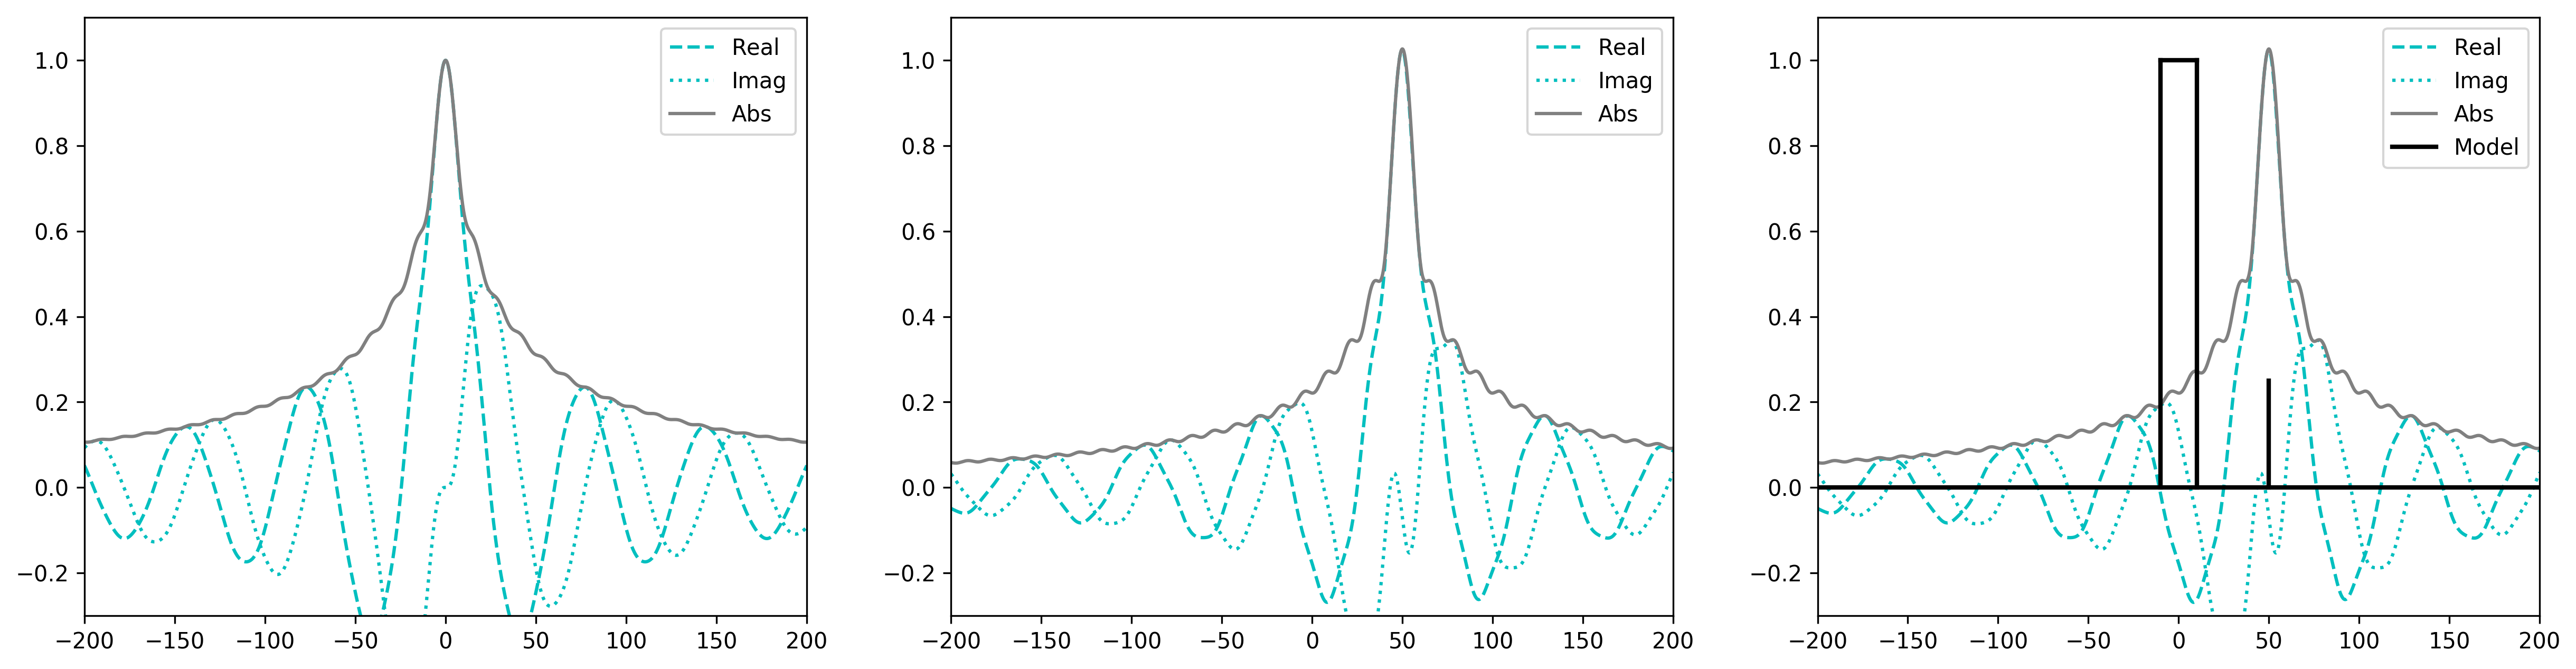

In [18]:
pl.subplot(131)
pl.plot(phi,np.real(rmtf),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(rmtf),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(rmtf),ls='-',c='grey',label="Abs")
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)
pl.legend()

pl.subplot(132)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.subplot(133)
pl.plot(phi,np.real(fspec),ls='--',c='c',label="Real")
pl.plot(phi,np.imag(fspec),ls=':',c='c',label="Imag")
pl.plot(phi,np.abs(fspec),ls='-',c='grey',label="Abs")

pl.plot(phi,np.zeros(len(phi)),ls='-',lw=2.,c='black')
if scen1:
    pl.plot([50.,50.],[0.,1.4],ls='-',lw=2.,c='black')
elif scen2:
    pl.plot([50.,50.],[0.,0.25],ls='-',lw=2.,c='black')
    pl.plot([10.,10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,-10.],[0.,1.0],ls='-',lw=2.,c='black')
    pl.plot([-10.,10.],[1.0,1.0],ls='-',lw=2.,c='black',label="Model")
    
pl.xlim(-200,200)
if scen1:
    pl.ylim(-0.3,1.5)
elif scen2:
    pl.ylim(-0.3,1.1)

pl.legend()

pl.show()